# Analyse mechanochem - predefined model

Here we are going to assume that the scission rate is given by:
$$
k = \alpha |\mathrm{tr}(A \nabla U)|^\beta \mathrm{tr}(A)^\gamma
$$
and we will use available data to fit the model parameters.


In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [15, 8]

## Datasets selection

In [314]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 100                      # Number of segments in the Kramers chain
n_ensemble = 1000                     # Number of molecules to simulate
n_proc = 16                         # Number of processor cores to use
seq = np.random.SeedSequence(2022)  # Random number seed

# Input folder
data_folder = 'outputs/Kramers'
                    
# Name: file
scenarios = [
    'turbulence_0',
    'turbulence_1',
    'turbulence_2',
    'turbulence_3',
    'turbulence_4',
    'inkjet_0',
    'inkjet_1',
    'inkjet_2',
    'inkjet_3',
    'inkjet_4',
    'contraction_0',
    'contraction_1',
    'contraction_2',
    'contraction_3',
    'contraction_4',
    'contraction_5',
    'contraction_6',
    'elongation_0',
    'random_0',
    'random_1',
    'random_2',
    'random_3',
    'random_4',
    'sonication_0',
    'sonication_1',
    'sonication_2',
    'sonication_3',
    'sonication_4',
]
# Load data with rescaling
dataset = {}
for scenario in scenarios:
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        # Rename and normalise variables
        tau = 0.0142*n_links**2
        temp['A'] = temp.pop('A_average')/n_links**2
        temp['∇U'] = temp.pop('gradU')*tau
        temp['t'] = temp['t']/tau
        dgradU = np.zeros_like(temp['∇U'])
        dgradU[1:] = np.diff(temp['∇U'], axis=0)/np.diff(temp['t'])[:, None, None]
        temp['d∇U'] = dgradU
        temp['tr(Ad∇U)'] = np.trace(temp['A']@temp['d∇U'], axis1=1, axis2=2)
        # Add transposed variables
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        # Principal strain rates
        temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))
        
        # Add features
        temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
        temp['tr(A∇U)'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2)
        # temp['tr(A∇U∇Uᵀ)'] = np.trace(temp['A']@temp['∇U']@temp['∇Uᵀ'], axis1=1, axis2=2)
        
        # Effective principal strain rate
        temp['w'] = temp['tr(A∇U)']/temp['tr(A)']
        
        # Estimates of the Henky strain, one using principal strain rates, the other using polymer extension
        h = np.zeros_like(temp['t'])
        h_prime = np.zeros_like(temp['t'])
        for i, dt in enumerate(np.diff(temp['t'])):
            h[i+1] = (np.amax(temp['epsilon_dot'][i]) + h[i]/dt)/(1./dt + 1./1.)
            h_prime[i+1] = (temp['tr(A∇U)'][i]/temp['tr(A)'][i] + h_prime[i]/dt)/(1./dt + 1./1.)
        temp['h'] = h
        temp['h_prime'] = h_prime
        
        # Effective square segment
        temp['L2'] = temp['g_max']/temp['epsilon_dot'][:,2]
        
        
        # Save
        dataset[scenario] = temp

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


## Simulate mechanophore activation and scission

For an elongated chain, the maximum tension is at the centre and given by:
$$
g_\max = Wi\left(\frac{N^2}{8} + \frac{N}{2} \right)
$$
So a critical tension corresponds to a critical Weissenberg number
$$
Wi_c = \frac{g_c}{\frac{N^2}{8} + \frac{N}{2}}
$$
And there is a critical Wi for mechanophore activation: $Wi_m$

In [315]:
Wi_c = 100
Wi_m = 10000
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)

for scenario, data in dataset.items():
    scission_events = np.zeros_like(data['t'])
    mechanophore_events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(data['g_max'], data['g_12']):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            if g_12 > mechanophore:
                # mechanophore activation
                mechanophore_events[i] += 1
                break
            if g_max > threshold:
                # Non-specific scission
                scission_events[i] += 1
                break
    data['c_scission'] = np.cumsum(scission_events)/n_ensemble
    data['c_mechanophore'] = np.cumsum(mechanophore_events)/n_ensemble
    data['c'] = 1. - (data['c_scission'] + data['c_mechanophore'])

    k = np.zeros_like(data['t'])
    k[1:] = np.diff(-np.log(data['c']+1e-6))/np.diff(data['t'])
    data['k'] = k
    
    # Smooth k using decrete cosine formulation
    #mirror = np.hstack((data['c'], np.flip(data['c'][1:])))
    #p_hat = np.fft.rfft(mirror)
    #f = np.fft.rfftfreq(len(mirror))
    #filter_ = np.exp(-(4*f)**2)
    #pop_smooth_m = np.fft.irfft(filter_*p_hat, n=len(mirror))
    # pop_smooth = pop_smooth_m[:len(data['c'])]
    
    width = 4
    data['c_smooth'] = np.convolve(data['c'], np.ones(width)/width, mode='same')
    data['c_smooth'][:width//2] = data['c'][:width//2]
    data['c_smooth'][-width//2:] = data['c'][-width//2:]
    
    k_smooth = np.zeros_like(data['t'])
    k_smooth[1:] = np.diff(-np.log(data['c_smooth']+1e-6))/np.diff(data['t'])
    k_smooth[k_smooth<1e-3] = 0
    data['k_smooth'] = k_smooth

880.2816901408451 88028.1690140845


Inspect the result:

In [316]:
def view_scission(scenario, zoom):
    t = dataset[scenario]['t'][zoom[0]:zoom[1]]
    
    plt.rcParams['figure.figsize'] = [15, 15]
    fig, ax = plt.subplots(nrows=5)
    ax[0].plot(t, dataset[scenario]['c'][zoom[0]:zoom[1]], label='c')
    ax[0].plot(t, dataset[scenario]['c_smooth'][zoom[0]:zoom[1]], label='c_smooth')
    ax[0].plot(t, dataset[scenario]['c_scission'][zoom[0]:zoom[1]], label='c_scission')
    ax[0].plot(t, dataset[scenario]['c_mechanophore'][zoom[0]:zoom[1]], label='c_mechanophore')
    ax[0].axhline(0, ls=':')
    ax[0].legend()
    ax[0].set_title('Population')
    
    ax[1].plot(t, dataset[scenario]['epsilon_dot'][zoom[0]:zoom[1]])
    ax[1].plot(t, dataset[scenario]['tr(A∇U)'][zoom[0]:zoom[1]]/dataset[scenario]['tr(A)'][zoom[0]:zoom[1]], 'k:')
    ax[1].set_title('Strain rates')
    
    ax[2].plot(t, dataset[scenario]['h'][zoom[0]:zoom[1]], 'k', label='from strain rate')
    ax[2].plot(t, dataset[scenario]['h_prime'][zoom[0]:zoom[1]], 'k:', label='estimate')
    ax[2].set_title('Henky strain')
    
    ax[3].plot(t, dataset[scenario]['k'][zoom[0]:zoom[1]])
    ax[3].plot(t, dataset[scenario]['k_smooth'][zoom[0]:zoom[1]])
    ax[3].set_title('k')
    
    ax[4].plot(t, dataset[scenario]['L2'][0,zoom[0]:zoom[1]])
    ax[4].plot(t, dataset[scenario]['L2'][1,zoom[0]:zoom[1]])
    ax[4].plot(t, dataset[scenario]['L2'][2,zoom[0]:zoom[1]])
    ax[4].plot(t, dataset[scenario]['L2'][3,zoom[0]:zoom[1]])
    ax[4].set_title('k')
    
    plt.show()

    
x_widget = widgets.Dropdown(options=list(dataset.keys()), value=list(dataset.keys())[0], description='Scenario:')
y_widget = widgets.IntRangeSlider(description='Zoom:', continuous_update=False)    

def update_models(*args):
    tmax = len(dataset[x_widget.value]['t'])
    y_widget.value=[0, tmax]
    y_widget.min=0
    y_widget.max=tmax
x_widget.observe(update_models)
    
ws = interactive(view_scission, 
                 scenario=x_widget,
                 zoom=y_widget
                )
ws

interactive(children=(Dropdown(description='Scenario:', options=('turbulence_0', 'turbulence_1', 'turbulence_2…

## Look for functional form

In [15]:
def view_3d(scenarios):
    #plt.rcParams['figure.figsize'] = [10, 8]
    #fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #for scenario in scenarios:
    #    h = dataset[scenario]['h_prime'][dataset[scenario]['k']>0]
    #    w = dataset[scenario]['tr(A∇U)'][dataset[scenario]['k']>0]/dataset[scenario]['tr(A)'][dataset[scenario]['k']>0]
    #    c = dataset[scenario]['c'][dataset[scenario]['k']>0]
    #    ax.scatter3D(h, w, c)
    #ax.set_xlabel('Effective Henky strain')
    #ax.set_ylabel('Effective strain rate')
    #ax.set_zlabel('c')
    #plt.show()
    
    plt.rcParams['figure.figsize'] = [7, 5]
    for scenario in scenarios:
        h = dataset[scenario]['h_prime'][dataset[scenario]['k']>0]
        
        w = dataset[scenario]['tr(A∇U)'][dataset[scenario]['k']>0]/dataset[scenario]['tr(A)'][dataset[scenario]['k']>0]
        #w = dataset[scenario]['epsilon_dot'][dataset[scenario]['k']>0][:,2]
        
        c = dataset[scenario]['c'][dataset[scenario]['k']>0]
        plt.scatter(h, np.log10(w/Wi_c), s=20, c=c)
    plt.xlabel('Effective Henky strain')
    plt.ylabel('Effective strain rate (normalsed by Wi_c)')
    #ax.set_zlabel('c')
    plt.show()
    
    
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, ax = plt.subplots(ncols=3)
    
    for scenario in scenarios:
        h_prime = dataset[scenario]['h_prime']
        w = dataset[scenario]['tr(A∇U)']/dataset[scenario]['tr(A)']
        trA = dataset[scenario]['tr(A)']
        ax[0].semilogy(h_prime[dataset[scenario]['k']>0], w[dataset[scenario]['k']>0], 
                       '*', alpha=0.5, label=scenario)
        ax[0].legend()
        ax[0].set_ylim(1, 2*Wi_max)
        ax[0].set_ylabel('Effective strain rate')
        ax[0].set_xlabel('Effective Henky strain')
        ax[0].axhline(Wi_c, ls=':')
        
        
        ax[1].semilogy(h_prime, trA, '.', alpha=0.5)
        ax[1].set_xlabel('Effective Henky strain')
        ax[1].set_ylim(1./n_links, 1)
        ax[1].set_ylabel('tr(A)')
        
        
        ax[2].semilogy(h_prime[dataset[scenario]['k']>0], dataset[scenario]['c'][dataset[scenario]['k']>0], '.', alpha=0.5)
#        ax[2].semilogy(h_prime, (1-trA)**np.log(Wi_max/Wi_c), 'k.', alpha=0.5)
#        ax[2].set_xlim(0, 1)
        ax[2].set_xlabel('Effective Henky strain')
        ax[2].set_ylim(1e-2, 1.2)
        ax[2].set_ylabel('c')
        
    # tr(A) master curve
    x = np.linspace(0, 2)
    ax[1].semilogy(x, np.exp(2*x-np.log(n_links)), 'k:')
    x = np.linspace(np.log(n_links)/2, 8)
    ax[1].semilogy(x, 1-np.exp(-x/2+np.log(n_links)/8), 'k-')
    ax[1].axvline(np.log(n_links)/2, ls=':')
    ax[1].axhline(n_links**(-0.5), ls=':')
    
    x = np.linspace(0, 8)
#    ax[2].semilogy(x, np.exp(-Wi_max/Wi_c/2*x+np.log(n_links)/8), 'k-')
    ax[2].axvline(np.log(n_links)/4-np.log(Wi_max/Wi_c)/3.5, ls=':')
    
    plt.show()
    
w3d = interactive(view_3d, 
                 scenarios=widgets.SelectMultiple(
                    options=list(dataset.keys()),
                    value=('elongation_0',),
                    #rows=len(dataset),
                    description='Scenarios:',
                    disabled=False
                    )
                )
w3d

interactive(children=(SelectMultiple(description='Scenarios:', index=(17,), options=('turbulence_0', 'turbulen…

## Model as $c=f(h,w)$

Since it seems that $c$ is approximately a function in the plane ($h$, $w$), we can look for the functional form only by looking at $w=C^{te}$, which are sudden elongation.

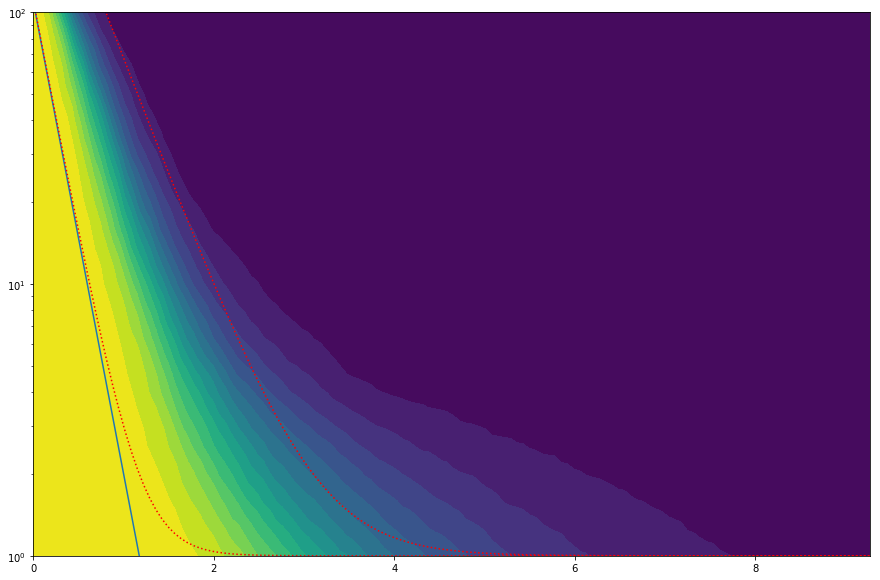

In [277]:

data = dataset['elongation_0']

cs = []
Wics = np.logspace(1,3,31)

for Wi_c in Wics:

    Wi_m = 10000
    threshold = Wi_c/(8*0.0142)
    mechanophore = Wi_m/(8*0.0142)
    scission_events = np.zeros_like(data['t'])
    mechanophore_events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(data['g_max'], data['g_12']):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            if g_12 > mechanophore:
                # mechanophore activation
                mechanophore_events[i] += 1
                break
            if g_max > threshold:
                # Non-specific scission
                scission_events[i] += 1
                break
    data['c_scission'] = np.cumsum(scission_events)/n_ensemble
    data['c_mechanophore'] = np.cumsum(mechanophore_events)/n_ensemble
    data['c'] = 1. - (data['c_scission'] + data['c_mechanophore'])
    cs.append(data['c'])

c_array = np.array(cs)
#c_array[c_array==1] = np.nan
#c_array[c_array==0] = np.nan

X, Y = np.meshgrid(data['h_prime'], Wi_max/Wics)

plt.contourf(X, Y, c_array, 16)
plt.plot(data['h_prime'],110*np.exp(-4*data['h_prime']))
plt.plot(data['h_prime'],110*np.exp(-4*(data['h_prime']))+1, 'r:')
plt.plot(data['h_prime'],100*np.exp(-2*(data['h_prime']-0.8))+1, 'r:')
plt.ylim(1,100)
plt.yscale('log')

Let's see if assumption is correct:

In [218]:
from scipy.interpolate import interp2d

c_sim = interp2d(data['h_prime'], Wi_max/Wics, c_array, kind='linear', bounds_error=False, fill_value=1)

Wi_c = 100

for scenario, data in dataset.items():
    w = data['tr(A∇U)']/data['tr(A)']
    data['c_sim'] = np.ones_like(data['t'])
    previous = 1
    for i, (ht, wt) in enumerate(zip(data['h_prime'][1:], w[1:]/Wi_c)):
        data['c_sim'][i+1] = min(data['c_sim'][i], c_sim(ht, wt))


(2618,)
(2618,)
(2618,)
(2618,)
(2618,)
(305,)
(409,)
(331,)
(326,)
(391,)
(1913,)
(1504,)
(1263,)
(1872,)
(1609,)
(1988,)
(2705,)
(142,)
(142,)
(142,)
(142,)
(142,)
(142,)
(3461,)
(3461,)
(3461,)
(3461,)
(3461,)


In [219]:
def view_fit(scenario):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.plot(dataset[scenario]['t'], dataset[scenario]['c'], label='Molecular dynamics')
    plt.plot(dataset[scenario]['t'], dataset[scenario]['c_sim'], label='model')
    plt.axhline(0, ls=':')
    plt.legend()
    plt.show()

wf = interactive(view_fit, 
                 scenario=widgets.Dropdown(
                    options=list(dataset.keys()),
                    value=next(iter(dataset.keys())),
                    description='Scenario:',
                    disabled=False,
                    )
                )
wf

interactive(children=(Dropdown(description='Scenario:', options=('turbulence_0', 'turbulence_1', 'turbulence_2…

Now look for functional form. We are going to fit log curves with a three points Bezier. 

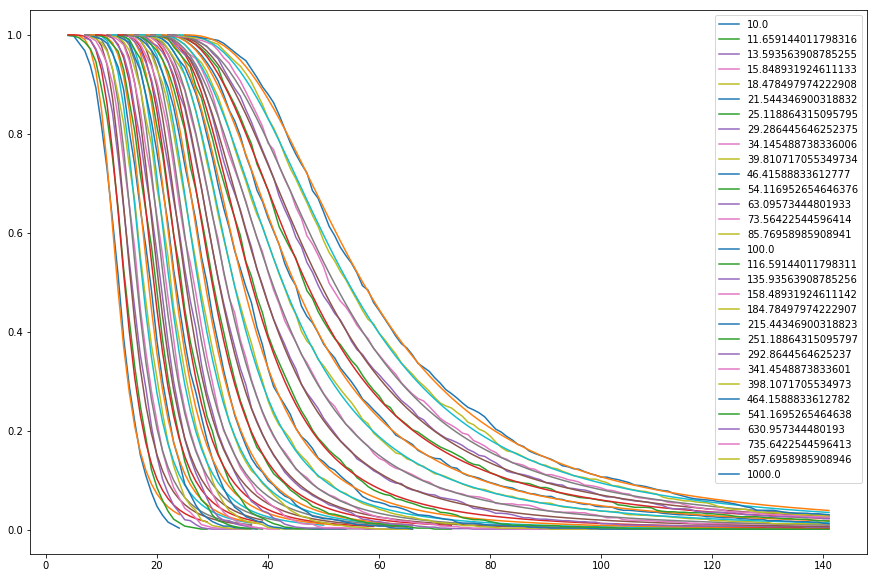

In [278]:
data = dataset['elongation_0']
h_prime = data['h_prime']
c_array[c_array==1] = np.nan
c_array[c_array==0] = np.nan

from scipy.optimize import curve_fit

c_model = c_array.copy()

alphas=[]
betas=[]

for i, c in enumerate(c_array):
    h_clean = h_prime[~np.isnan(c)]
    c_clean = c[~np.isnan(c)]
    (alpha, beta), _ = curve_fit(lambda x, alpha, beta: 1./(1+alpha*x**beta), h_clean-h_clean[0], c_clean, p0=(1,1))
    
    x = h_clean-h_clean[0]
    c_model[i, ~np.isnan(c)] = 1./(1+alpha*x**beta)
    alphas.append(alpha)
    betas.append(beta)

    
for c, c_mo, Wi in zip(c_array, c_model, Wics):
    plt.plot(c, label=Wi)
    plt.plot(c_mo)
    
plt.legend()

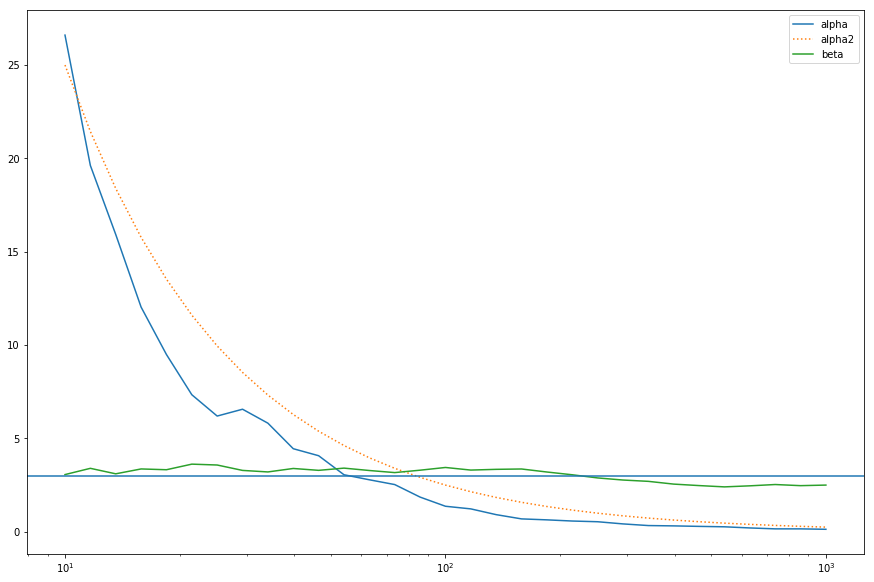

In [301]:
plt.semilogx(Wics, alphas, label='alpha')
plt.semilogx(Wics, 250/Wics, ':', label='alpha2')
plt.semilogx(Wics, betas, label='beta')
plt.axhline(3)
plt.legend()

## Optimise parameters

In [6]:
from scipy.optimize import minimize, shgo

fit_set = {
#    'turbulence_0',
#    'turbulence_1',
#    'turbulence_2',
#    'turbulence_3',
#    'turbulence_4',
#    'inkjet_0',
#    'inkjet_1',
#    'inkjet_2',
#    'inkjet_3',
#    'inkjet_4',
    'contraction_0',
    'contraction_1',
    'contraction_2',
    'contraction_3',
    'contraction_4',
    'contraction_5',
    'contraction_6',
#    'elongation_0',
#    'random_0',
#    'random_1',
#    'random_2',
#    'random_3',
#    'random_4',
    'sonication_0',
    'sonication_1',
    'sonication_2',
    'sonication_3',
    'sonication_4',
}

def cost(params):
    total_cost = 0.
    for scenario in fit_set:
        T0 = Wi_m/params[0]
        #T0 = Wi_m/n_links**0.5
        T = dataset[scenario]['tr(A∇U)'] > T0
        k = T*params[1]*(np.abs(dataset[scenario]['tr(A∇U)']-T0))**1 *dataset[scenario]['tr(A)']**0
        c_sim = np.ones_like(dataset[scenario]['c'])
        c_sim[1:] = np.exp(-np.cumsum(k[1:]*np.diff(dataset[scenario]['t'])))
        total_cost += np.average((dataset[scenario]['c']-c_sim)**2)
    return total_cost
        
res = minimize(cost, x0=[1.,1., 1, 0])
bounds = [(1,50), (0, 1), (1.5, 2.5)]
#res = shgo(cost, bounds, n=10000, iters=3)

In [7]:
res

      fun: 0.640252802281142
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1., 1., 1., 0.])

In [8]:
for scenario, data in dataset.items():
    #T0 = Wi_m*dataset[scenario]['tr(A)']/res.x[0]
    T0 = Wi_m/n_links**0.5
    T = dataset[scenario]['tr(A∇U)'] > T0
    k = T*res.x[1]*(np.abs(dataset[scenario]['tr(A∇U)']-T0))**res.x[2] *dataset[scenario]['tr(A)']**res.x[3]
    c_sim = np.ones_like(data['c'])
    c_sim[1:] = np.exp(-np.cumsum(k[1:]*np.diff(data['t'])))
    data['c_sim'] = c_sim

In [9]:
def view_fit(scenario):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.plot(dataset[scenario]['t'], dataset[scenario]['c'], label='Molecular dynamics')
    plt.plot(dataset[scenario]['t'], dataset[scenario]['c_sim'], label='model')
    plt.axhline(0, ls=':')
    plt.legend()
    plt.show()

wf = interactive(view_fit, 
                 scenario=widgets.Dropdown(
                    options=list(dataset.keys()),
                    value=next(iter(dataset.keys())),
                    description='Scenario:',
                    disabled=False,
                    )
                )
wf

interactive(children=(Dropdown(description='Scenario:', options=('turbulence_0', 'turbulence_1', 'turbulence_2…

In [10]:
import scipy
scipy.__version__

'1.7.3'

In [66]:
np.log(100)

4.605170185988092

In [91]:
1.8*4-1

6.2

In [92]:
6.2**2

38.440000000000005

In [95]:
4/np.log(2)

5.7707801635558535

In [96]:
2*7.06/4.2

3.3619047619047615

In [97]:
5.77-3.36

2.4099999999999997